# Welche quantitativen Eigenschaften hat der Bachkorpus in der Textdarstellung?

Dieses Notebook dient der Ergänzung von gen_LSTM.ipynb. Es sollen die Gedanken und Methoden dargelegt werden, welche zur Wahl der Hyperparameter 'Sequenzlänge', 'Padding' und 'Emebedding Dimension' führten.

In [1]:
# Imports:

from music21 import *

from myHelper import getVocab, part2List  
from sklearn import metrics 
import networkx as nx

from itertools import groupby
import numpy as np
import matplotlib.pyplot as plt

import timeit
from datetime import datetime # model IDs

import os # handle files 

## Weg zur Sequenzelänge und zur Art und Ausführung des Paddings

In [2]:
# Gesamtzahl der verhandenen Werke von Bach
paths = corpus.getComposer('bach')
print(len(paths))

433


In [3]:
bachBundle = corpus.search('bach', 'composer') 
print(bachBundle)
bachBundle.search('4/4')

<music21.metadata.bundles.MetadataBundle {363 entries}>


<music21.metadata.bundles.MetadataBundle {321 entries}>

In [4]:
corp_44 = bachBundle.search('4/4')[0].parse()

In [5]:
bach_44 = []
for work_bach in bachBundle.search('4/4'):
    bach_44.append(work_bach.parse())
print(len(bach_44))

321


### Vorbetrachtung der Werke im 4/4-Takt

In [6]:
num_parts = []
max_elements = 0
min_elements = 999
nr_sums = []
for score_44 in bach_44: #  Alle Werke durchgehen
    temp_parts = score_44.parts # Alle Parts des aktuelle Werkes ablegen
    num_parts.append(len(temp_parts)) # Parts zaehlen
    
    for part in temp_parts:
        part = part.recurse()
        num_notes = len(part.getElementsByClass(note.Note))
        num_rests = len(part.getElementsByClass(note.Rest))
        nr_sum = num_notes + num_rests
        nr_sums.append(nr_sum)
        #print(nr_sum)
        if nr_sum < min_elements and nr_sum > 0:
            min_elements = nr_sum
        if nr_sum > max_elements:
            max_elements = nr_sum
    
print('Number of scores:', len(num_parts))
print('Number of parts:', sum(num_parts))
print('Average number of parts:', sum(num_parts)/len(num_parts))
print('Max number of elments: ', max_elements)
print('Min number of elements: ', min_elements)
print('Average number of elements: ', np.average(nr_sums))
print('Median number of elements: ', np.median(nr_sums))

Number of scores: 321
Number of parts: 1264
Average number of parts: 3.9376947040498442
Max number of elments:  543
Min number of elements:  23
Average number of elements:  58.53322784810127
Median number of elements:  53.0


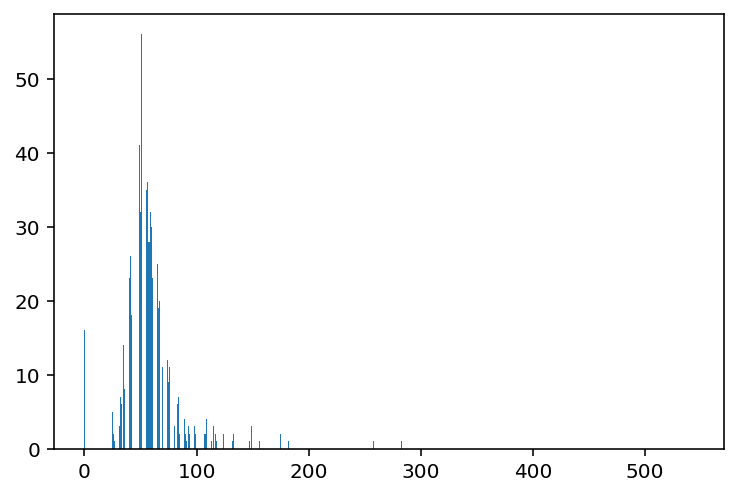

In [7]:
# Historgram alle 4/4 Werke im Corpus
num_bins = sum(num_parts)

fig = plt.hist(nr_sums, bins=num_bins)

Die obige Ausgabe ergibt damit den Kern der Vorarbeit und wir stellen fest:
- Anzahl der Elemente liegt zwischen 23 und 484
- Durchschnitt und Median liegen nahe beieinander
- extrem Lange Stücke könnten später das Training verzerren, da diese viele Subsequenzen erzeugen

### Ein weiterer Filter
Da unter Umständen rhythmische Unterschiede zwischen den Stimmen(Parts) eines Stückes bestehen, wollen wir im Folgenden nur die jeweils ersten Stimmen betrachten.

In [8]:
# Nur erste Parts aus dem 4/4-Corpus

max_elements_val = 0
min_elements_val = 999
nr_sums_list = [] # sums of notes+rests
for score_44 in bach_44: #  Alle Werke durchgehen
    #temp_parts = score_44.parts # Alle Parts des aktuelle Werkes ablegen
    # num_parts.append(len(temp_parts)) # Parts zaehlen
    
    part = score_44.parts[0]
    part = part.recurse()
    num_notes = len(part.getElementsByClass(note.Note))
    num_rests = len(part.getElementsByClass(note.Rest))
    nr_sum = num_notes + num_rests
    nr_sums_list.append(nr_sum)
    #print(nr_sum)
    if nr_sum < min_elements_val and nr_sum > 0:
        min_elements_val = nr_sum
    if nr_sum > max_elements_val:
        max_elements_val = nr_sum
    
#print('Number of scores:', len(num_parts))
#print('Number of parts:', sum(num_parts))
#print('Average number of parts:', sum(num_parts)/len(num_parts))
print('Max number of elments: ', max_elements_val)
print('Min number of elements: ', min_elements_val)
print('Average number of elements: ', np.average(nr_sums_list))
print('Median number of elements: ', np.median(nr_sums_list))

Max number of elments:  543
Min number of elements:  23
Average number of elements:  50.299065420560744
Median number of elements:  46.0


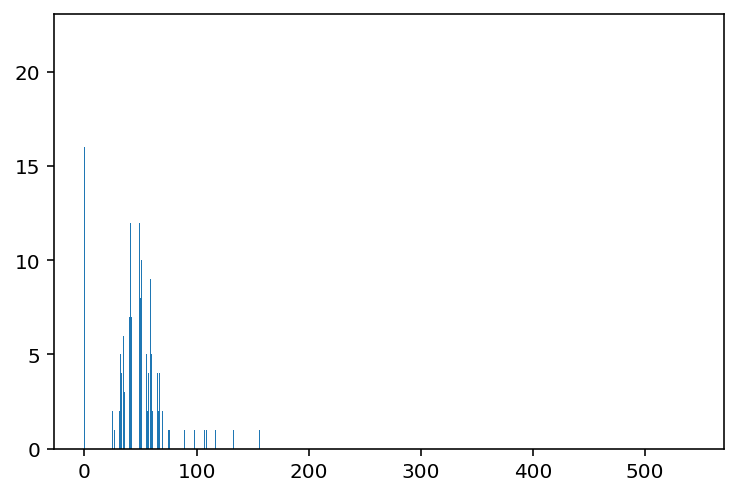

In [9]:
# Historgram
num_bins = sum(num_parts)

fig = plt.hist(nr_sums_list, bins=num_bins)

Wie zu erwarten ergeben sich auch nur mit den ersten Stimmen ähnliche Probleme.

In [10]:
nr_sums_list.sort()
print(nr_sums_list)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 23, 23, 25, 25, 27, 29, 29, 30, 30, 31, 31, 32, 32, 32, 32, 32, 33, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 36, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 56, 56, 57, 57, 57, 57, 59, 59, 59, 59, 59, 59,

In [11]:
nr_sums_list.sort()
#print(nr_sums_list)

frequencies_list = [len(list(group)) for key, group in groupby(nr_sums_list)]
nr_sums_set = set(nr_sums_list)
sum_list = list(nr_sums_set)
sum_list.sort()

frequencies_dict = dict((x,y) for x, y in zip(sum_list,frequencies_list))

print("frequencies_dict")
print(frequencies_dict)

frequencies_dict
{0: 16, 23: 2, 25: 2, 27: 1, 29: 2, 30: 2, 31: 2, 32: 5, 33: 4, 34: 7, 35: 6, 36: 3, 37: 11, 38: 7, 39: 7, 40: 7, 41: 12, 42: 7, 43: 15, 44: 14, 45: 13, 46: 22, 47: 9, 48: 8, 49: 12, 50: 8, 51: 10, 52: 11, 53: 7, 54: 5, 55: 5, 56: 2, 57: 4, 59: 9, 60: 5, 61: 2, 62: 2, 63: 4, 64: 7, 65: 4, 66: 2, 67: 4, 68: 2, 69: 2, 70: 2, 71: 2, 72: 3, 75: 1, 76: 1, 78: 1, 81: 1, 82: 2, 86: 1, 87: 2, 89: 1, 92: 1, 98: 1, 103: 1, 105: 3, 107: 1, 109: 1, 117: 1, 133: 1, 156: 1, 187: 1, 543: 1}


- kleiner als 32 -> Anzahl der Stücke dieser Länge sehr gering, Informationsgehalt auch. 
- grösser als 60 -> Anzahl nimmt auch ab, werden im Verhältnis zu 32 auch sehr lang
- Angenommen minimale Länge -> 150 Elemente in Sequenz, maximal 60 -> 300 

### Nochmal Statistik

In [12]:
median_sums = np.median(nr_sums_list)
average_sums = np.average(nr_sums_list)
perc_12_sums = np.percentile(nr_sums_list, 12.5)
perc_87_sums = np.percentile(nr_sums_list, 87.5)

print('Median number of elements:', median_sums)
print('Average number of elements:',average_sums)
print('12.5-percentile of elements:', perc_12_sums)
print('87.5-percentile of elements:', perc_87_sums)

Median number of elements: 46.0
Average number of elements: 50.299065420560744
12.5-percentile of elements: 34.0
87.5-percentile of elements: 65.0


Damit hätten wir bei min=30 und max=65 mehr als 75% des Datensatzes abegedeckt und muessten mit einer maximalen Laenge von 325 arbeiten.

### Erstellen des Wortschatzes

In [13]:
# Filterparameter
composer = 'bach'
time_ratio = '4/4'
min_elem_filter = 30
max_elem_filter = 65

In [14]:
pitch_classes, octaves, durations, dots = getVocab(composer, time_ratio, min_elem_filter, max_elem_filter)

Number of parts:  258


In [15]:
other = ['null',' ']
print(pitch_classes)
print(durations)
print(octaves)
print(dots)

['E-', 'G', 'F#', 'A-', 'G-', 'D#', 'B-', 'C#', 'D-', 'A', 'A#', 'C', 'F', 'D', 'E', 'G#', 'B']
['16th', 'quarter', 'half', 'eighth', '32nd', 'whole']
['o4', 'o3', 'o6', 'o5']
['d1', 'd0']


In [16]:
# Ueberfuehrung in Dictionary
words = other + pitch_classes + durations + dots + octaves
word_to_int = dict((word, number) for number, word in enumerate(words))
print(word_to_int)

{'null': 0, ' ': 1, 'E-': 2, 'G': 3, 'F#': 4, 'A-': 5, 'G-': 6, 'D#': 7, 'B-': 8, 'C#': 9, 'D-': 10, 'A': 11, 'A#': 12, 'C': 13, 'F': 14, 'D': 15, 'E': 16, 'G#': 17, 'B': 18, '16th': 19, 'quarter': 20, 'half': 21, 'eighth': 22, '32nd': 23, 'whole': 24, 'd1': 25, 'd0': 26, 'o4': 27, 'o3': 28, 'o6': 29, 'o5': 30}


### Gedanken zu Sequenzen, Padding und Leistungsfähigkeit des Modells

Erinnerung: Wir wollen nicht ganze Stücke (bzw. deren Parts) eingeben, sondern Subparts. 

**Idee**:<br>
Modell erwartet bisher Sequenzen der Länge 200.  
-> Eingabe bis 250 sollte machbar sein  
Pro Note braucht man 5 Elemente einer Sequenz (inklusive Trennzeichen), pro Pause 3  
-> aus einem Stück mit 65 Elementen wird eine Sequenz mit maximal 325 Elementen (falls nur Noten enthalten sind) 

**Minimale Länge**:<br>
Vernachlässigen wir Pausen, dann hieße eine minimale Länge eines Stückes von 30 Elementen, dass ca. die Hälfte der Sequenz mit sinnvoller Information gefüllt wäre, der Rest mit reinem Padding.  

**Länge des Padding**:<br>
Es wird bei der Übersetzung von Stream zu String-Liste gepaddet. Eingabelisten (Subparts) werden aus den String-Listen erstellt. Padden wir auf eine Länge von 350, so erhielten wir 100 Trainingsfälle pro Musikstück. Im Schlimmsten Fall, also bei Länge 150 (aus 30 Elementen), würde eine Sequenz mit 200-mal PADDING-ELEMENT und den ersten 50 Elemten der Sequenz erzeugt.  

*Problem 1*:<br>
Bei reinem Backpadding, erhalten wir aus den 30er Stuecken nur Trainingsfälle bei denen weiteres Padding vorhergesagt wird. Ausserdem können nur die letzten Elemente vorhergesagt werden. Um auch das erste Element vorhersagen zu können, müssten wir Frontpadding der Länge 299 anwenden.

*Problem 2*:<br>
Es können nur die letzten 100 Elemente einer Sequenz sinnvoll vorhergesagt werden und damit nur 20 Noten.

# Beispiel

**Annahme:**
- Eingabelänge 10  
- Padding auf 15  
- Stücke liegen in (vereinfachter) String Codierung vor  

**i.A.:**<br>
Es entstehen in den Fällen 'kürzer' und 'gleich' jeweils 5 Trainingsfälle.  
Im Fall 'länger' entstehten STUECKLAENGE-EINGABELAENGE+1 viele Fälle.


**Fall 1**: *Stück ist länger als minimale Eingabe.*<br>
*Stück:*  
A D E C E A G E C E A B E B E A 

*Mit Padding:*  
A D E C E A G E C E A B E B E  

*Trainingsfälle (6):*  
X: A D E C E A G E C E ,Y: A  
X: D E C E A G E C E A ,Y: B  
X: E C E A G E C E A B ,Y: E  
X: C E A G E C E A B E ,Y: B  
X: E A G E C E A B E B ,Y: E  
X: A G E C E A B E B E ,Y: A  

**Fall 2:** *Stück ist gleich lang wie die minimale Eingabe.*<br>
*Stück:*
A D E C E A G E C E  
<br>
*Mit Padding:*
A D E C E A G E C E - - - - -  

*Trainingsfälle(5):*  
X: A D E C E A G E C E ,Y: -  
X: D E C E A G E C E - ,Y: -  
X: E C E A G E C E - - ,Y: -  
X: C E A G E C E - - - ,Y: -  
X: E A G E C E - - - - ,Y: -  

**Fall 3:** *Stück ist kürzer als minimale Eingabe.*  
*Stück:*
A B E B E  

*Mit Padding:*
A B E B E - - - - - - - - - -  

*Trainingsfälle(5):*  
X: A B E B E - - - - - ,Y: -  
X: B E B E - - - - - - ,Y: -  
X: E B E - - - - - - - ,Y: -  
X: B E - - - - - - - - ,Y: -  
X: E - - - - - - - - - ,Y: -  

# Embedding

https://www.aclweb.org/anthology/I17-2006

Das oben genannten Paper schlägt einen Algorithmus zur Bestimmung der minimalen Embedding-Dimension vor. Diesem wollen im Folgenden nachgehen.

# Schritt 1

*'Compute the word x word co-occurence matrix from the corpus.'*

**Problem: Welche Fenstergröß? In welcher Einheit die Fenstergröße messen?**
- Anzahl einzelner Elemente macht wenig Sinn, da nur 4er (Noten) bzw 2er (Pausen) Gruppen sinnvolle Aussagen ergeben. Bei Fenstergröße, aber kein Bezug zu anderen Wörtern
- Will man rythmische oder melodische Struktur als Semantik interpretieren reicht eine Größe von 4 z.B. nicht aus. 
- **Option A:** naheliegend: äquivalent zum NLP, das Fester als 'ganzer Takt' (Also Takt=Satz). D.h. durch alle Takte iterieren. ->Problem: kein Bezug zu vorherigen Takten
- **Option B:** Fenstergröße als durchschnittliche Taktlänge. Bsp ein Takt enthält im Durchscnitt 4 Noten und 0 Pause -> D.h. 4\*4+4=20 Elemente (bzw von einem einzelnen Element 10 nach links und nach rechts). Problem -> Ränder? Oder Jeder Takt hat im Durchschnitt 5 Noten oder Pausen -> Fasse immer 5 Elemente zu einem Satz zusammen.
- Fenster dürfen nicht überlappen. D.h. Fenster in Takten definieren
- **Lösung: Wir testen einfach verschiedene Festerngrößen.** 

In [17]:
pitch_classes_cm, octaves_cm, durations_cm, dots_cm = getVocab(composer, time_ratio, min_elem_filter, max_elem_filter)
# Nochmal Wortschatz
other_cm = [' ']
words_cm = other_cm + pitch_classes_cm + durations_cm + dots_cm + octaves_cm
word_to_int_cm = dict((word, number) for number, word in enumerate(words_cm))
print(word_to_int_cm)
print(len(word_to_int_cm))

Number of parts:  258
{' ': 0, 'E-': 1, 'G': 2, 'F#': 3, 'A-': 4, 'G-': 5, 'D#': 6, 'B-': 7, 'C#': 8, 'D-': 9, 'A': 10, 'A#': 11, 'C': 12, 'F': 13, 'D': 14, 'E': 15, 'G#': 16, 'B': 17, '16th': 18, 'quarter': 19, 'half': 20, 'eighth': 21, '32nd': 22, 'whole': 23, 'd1': 24, 'd0': 25, 'o4': 26, 'o3': 27, 'o6': 28, 'o5': 29}
30


In [18]:
def getCoocMatrix(vocab, corpus, context_size):
    min_elem = 30
    max_elem = 65
    padding_target_length = 0
    co_matrix = np.zeros((len(vocab),len(vocab))) # Matrix erstellen
    
    part_count = 0
    
    for work in corpus:
        temp_score = work.parse() # Werk einlesen und parsen
        
        part = temp_score.parts[0]
        part_rec = part.recurse() # plaetten
        
        # relevante Elemente zaehlen und evtl den Part ueberspringen
        notes_and_rests = list(part_rec.getElementsByClass([note.Note,note.Rest]))
        nr_sum = len(notes_and_rests)

        if min_elem <= nr_sum <= max_elem: # Falls die Anzahl der Elemente den Vorgaben entspricht
            part_str = part2List(notes_and_rests,padding_target_length) # Laenge des Paddings vorne/hinten, ganzzahlig und aufgerundet
            
            for ix,elem_part in enumerate(part_str):
                    
                min_ix = 0
                max_ix = len(part_str)
                
                if ix-context_size > 0: # minimaler Index wird nicht unterschritten 
                    min_ix = ix-context_size
                if ix+context_size < max_ix: # maximaler Index wird nicht ueberschritten
                    max_ix = ix+context_size+1
    
                window = part_str[min_ix:max_ix] # Fenster ausschneiden
                window.pop(ix-min_ix) # Kernelemente aus dem Fenster entfernen
                
                for elem_win in window: # co_matrix entsprechend der Elemente 'befuellen'
                    co_matrix[vocab[elem_part],vocab[elem_win]] += 1
            
            part_count += 1
        
    print('coMatrix parts = ', part_count)
                    
    return co_matrix
            

### Verdeutlichung an einfachem Beispiel

In [19]:
test_list = ['a','b','c','d','e','f','g','h','i','j','k','l']
ix = 4
elem = 'e'
context_size = 3
print(len(test_list))
print(test_list[11:12])

for ix in range(len(test_list)):
    min_ix = 0
    max_ix = len(test_list)
                
    if ix-context_size > 0: # minimaler Index wird nicht unterschritten 
        min_ix = ix-context_size
    if ix+context_size < max_ix: # maximaler Index wird nicht ueberschritten
        max_ix = ix+context_size+1
    
    window = test_list[min_ix:max_ix]
    window.pop(ix-min_ix)
    
    print('-----')
    print(test_list[ix])
    print(window)
    print('max',max_ix)
    print('min',min_ix)
    

12
['l']
-----
a
['b', 'c', 'd']
max 4
min 0
-----
b
['a', 'c', 'd', 'e']
max 5
min 0
-----
c
['a', 'b', 'd', 'e', 'f']
max 6
min 0
-----
d
['a', 'b', 'c', 'e', 'f', 'g']
max 7
min 0
-----
e
['b', 'c', 'd', 'f', 'g', 'h']
max 8
min 1
-----
f
['c', 'd', 'e', 'g', 'h', 'i']
max 9
min 2
-----
g
['d', 'e', 'f', 'h', 'i', 'j']
max 10
min 3
-----
h
['e', 'f', 'g', 'i', 'j', 'k']
max 11
min 4
-----
i
['f', 'g', 'h', 'j', 'k', 'l']
max 12
min 5
-----
j
['g', 'h', 'i', 'k', 'l']
max 12
min 6
-----
k
['h', 'i', 'j', 'l']
max 12
min 7
-----
l
['i', 'j', 'k']
max 12
min 8


### Weiter mit Schritt 1

In [49]:
# Corpus einlesen und filtern
composer = 'bach'
time_ratio = '4/4'

data_corp = corpus.search(composer,'composer')
data_corp = data_corp.search(time_ratio)

In [72]:
# Matrix erstellen
context_size = 25 # Fenstergroesse
co_matrix = getCoocMatrix(word_to_int_cm, data_corp, context_size)

coMatrix parts =  258


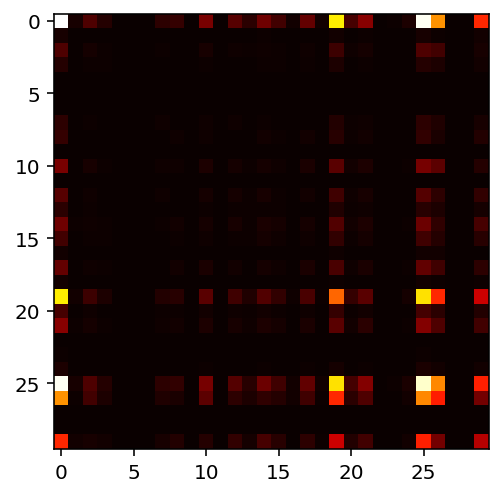

In [73]:
# Matrix plotten
plt.imshow(co_matrix, cmap='hot', interpolation='nearest')
plt.show()

### Nähere Betrachtung der Matrix
(für den Algorithmus zunächst uninteressant)

In [74]:
for i,elem in enumerate(word_to_int_cm):
    print('index: ',i,' ',elem,': ',sum(co_matrix[i,:]))

index:  0     :  566864.0
index:  1   E- :  11378.0
index:  2   G :  58118.0
index:  3   F# :  22935.0
index:  4   A- :  2119.0
index:  5   G- :  339.0
index:  6   D# :  1768.0
index:  7   B- :  29949.0
index:  8   C# :  35269.0
index:  9   D- :  1184.0
index:  10   A :  91979.0
index:  11   A# :  793.0
index:  12   C :  63825.0
index:  13   F :  26394.0
index:  14   D :  84568.0
index:  15   E :  46959.0
index:  16   G# :  8052.0
index:  17   B :  76021.0
index:  18   16th :  7259.0
index:  19   quarter :  402063.0
index:  20   half :  49802.0
index:  21   eighth :  104910.0
index:  22   32nd :  300.0
index:  23   whole :  2534.0
index:  24   d1 :  15146.0
index:  25   d0 :  551720.0
index:  26   o4 :  325187.0
index:  27   o3 :  50.0
index:  28   o6 :  159.0
index:  29   o5 :  236256.0


In [75]:
# ohne ' '
cm_slice = co_matrix[1:,1:]

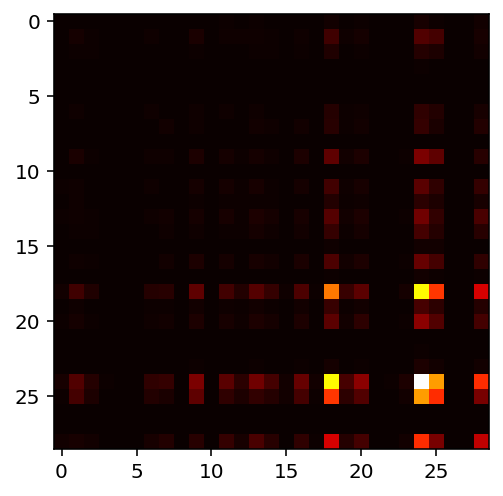

In [76]:
plt.imshow(cm_slice, cmap='hot', interpolation='nearest')
plt.show()

# Schritt 2

*'Create the word x word cosine similarity matrix by treating the rows of co-occurrence matrix as word vectors'*

Netter Weise ist die cosine-similarity-Matrix in sklearn.metrics schon vorimplementiert.

In [77]:
cos_sim_matrix = metrics.pairwise.cosine_similarity(co_matrix, Y=None, dense_output=False)

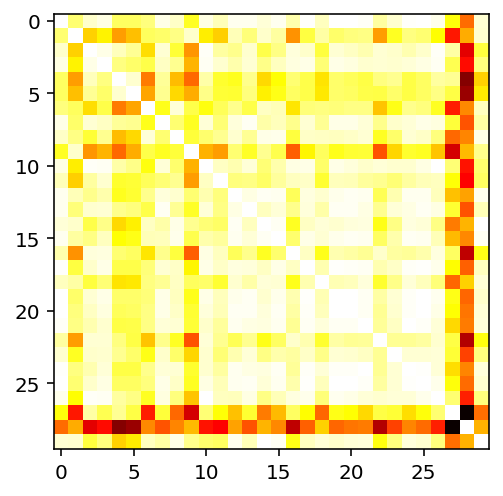

In [78]:
# Plot
plt.imshow(cos_sim_matrix, cmap='hot', interpolation='nearest')
plt.show()

# Schritt 3 und 4

*3)*
*For each similarity value s_k :*
- *a) (i) Create a graph, where the words are nodes. (ii) Create an edge between node i and node j if sim(i,j) = s_k*
- *b) Find maximum clique on this graph. The number of nodes in this clique is the maximum number of pairwise equidistant points E_k*
- *c) Reverse lookup E_k in table 3 to determine the corresponding number of dimension λ_k*

|      λ       |     E     |
|--------------|-----------|
|      3       |     6     |
|      4       |     6     |
|      5       |    10     |
|      6       |    16     |
|   7-13   |    28     |
|     14       |    30     |

*4)*
*The maximum the maximum λ among all λ_k_s is the lower bound.*

Wir nutzen dazu networkz und ein wenig Graphentheorie.

In [79]:
sim_graph = nx.Graph() # leeren Graph erstellen

In [80]:
# Schritt 3 a) i)
# Knoten (nodes) hinzufuegen und entsprechende Namen geben
for i,elem in enumerate(word_to_int_cm):
    sim_graph.add_nodes_from([(i,{'name':elem})])

In [81]:
# check
for name in sim_graph.nodes.data('name'):
    print(name)

(0, ' ')
(1, 'E-')
(2, 'G')
(3, 'F#')
(4, 'A-')
(5, 'G-')
(6, 'D#')
(7, 'B-')
(8, 'C#')
(9, 'D-')
(10, 'A')
(11, 'A#')
(12, 'C')
(13, 'F')
(14, 'D')
(15, 'E')
(16, 'G#')
(17, 'B')
(18, '16th')
(19, 'quarter')
(20, 'half')
(21, 'eighth')
(22, '32nd')
(23, 'whole')
(24, 'd1')
(25, 'd0')
(26, 'o4')
(27, 'o3')
(28, 'o6')
(29, 'o5')


In [82]:
unique_sk = np.unique(cos_sim_matrix) # similartiy values bestimmen

E_k = []
num_edges = []

for sk in unique_sk: # for jeden similarty value
    sim_graph = nx.Graph() # Graph erstellen
    for i,elem in enumerate(word_to_int_cm): # Knoten entsprechend der Woerter hinzufuegen
        sim_graph.add_nodes_from([(i,{'name':elem})])
        
    for i in range(len(cos_sim_matrix)): # Kanten zwischen Knoten i und j, falls cos_sim(i,j) = s_k
        for j in range(len(cos_sim_matrix)):
            if cos_sim_matrix[i][j] == sk:
                sim_graph.add_edge(i,j)
                
    num_edges.append(len(sim_graph.edges()))
    E_k.append(nx.graph_clique_number(sim_graph)) # groesse der maximalen Clique im Graphen

print('max E_k:',max(E_k)) # Es genuegt offensichtlich das maximale E_k zu betrachten

max E_k: 2


Wir können damit eine Embedding-Dimension von 3 wählen.